In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline 
import seaborn as sns  

In [21]:
# load data and get some insight
pdata = pd.read_excel("data.xlsx")
pdata.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


In [22]:
pdata.drop(pdata.columns[[0,1]], inplace=True, axis=1)

unique_values = pdata.nunique()
print('Count unique values in each column')
print(unique_values)

Count unique values in each column
Avg_Credit_Limit       110
Total_Credit_Cards      10
Total_visits_bank        6
Total_visits_online     16
Total_calls_made        11
dtype: int64


In [23]:
pdata.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Avg_Credit_Limit,660.0,34574.242424,37625.487804,3000.0,10000.0,18000.0,48000.0,200000.0
Total_Credit_Cards,660.0,4.706061,2.167835,1.0,3.0,5.0,6.0,10.0
Total_visits_bank,660.0,2.403030,1.631813,0.0,1.0,2.0,4.0,5.0
Total_visits_online,660.0,2.606061,2.935724,0.0,1.0,2.0,4.0,15.0
Total_calls_made,660.0,3.583333,2.865317,0.0,1.0,3.0,5.0,10.0


In [24]:
print("Missing values:\n{}".format(pdata.isnull().sum()))

Missing values:
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64


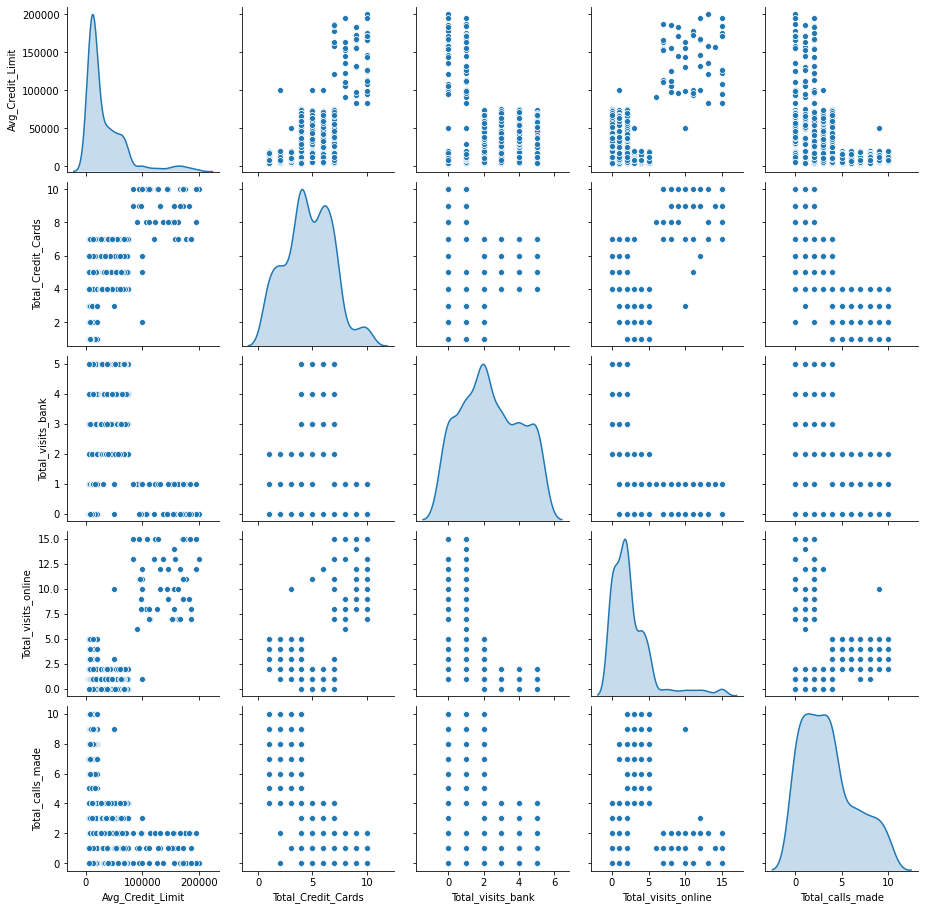

In [25]:
sns.pairplot(pdata, diag_kind='kde') 